In [1]:
from datetime import datetime, timedelta
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
datelist = pd.date_range(datetime.today(), periods=100).tolist()
from time import sleep
import dask.dataframe as dd
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
import os
import glob
from datetime import date

from uuid import uuid4


from shapely.geometry import Polygon, MultiPolygon, LineString, GeometryCollection

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import geopandas as gpd
import seaborn as sns

import dask.dataframe as dd
import geopandas as gpd
from detect_heatwaves import detect
from datetime import timedelta
import seaborn as sns
from datetime import date
import matplotlib.pyplot as plt

import os

In [2]:
full_df = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/daily_max/Turkey/THI_daily_max_turkey.csv')

full_df.rename(columns={'time': 'datetime'}, inplace=True)
full_df['datetime'] = pd.to_datetime(full_df['datetime'])
full_df['day'] = pd.DatetimeIndex(full_df['datetime']).day
full_df['month'] = pd.DatetimeIndex(full_df['datetime']).month
full_df['year'] = pd.DatetimeIndex(full_df['datetime']).year
full_df = full_df[~full_df['month'].isin([4, 10])]
full_df['location'] = full_df['adm2'] + ', ' + full_df['adm1']
full_df['datetime_ord'] = [date(x,y,z).toordinal() for x,y,z in zip(full_df['year'], full_df['month'], full_df['day'])]

In [3]:
full_df

,Unnamed: 0.1,Unnamed: 0,datetime,number,spatial_ref,t2m,d2m,rh,thi,adm2,adm1,day,month,year,location,datetime_ord
0,0,0,2018-05-01,0.0,0.0,17.999054,12.289337,98.894485,17.648025,Sisli,Istanbul,1,5,2018,"Sisli, Istanbul",736815
1,1,1,2018-05-02,0.0,0.0,19.233185,12.793976,94.001050,18.935583,Sisli,Istanbul,2,5,2018,"Sisli, Istanbul",736816
2,2,2,2018-05-03,0.0,0.0,20.876130,14.280426,92.362720,20.741085,Sisli,Istanbul,3,5,2018,"Sisli, Istanbul",736817
3,3,3,2018-05-04,0.0,0.0,20.111237,13.919098,97.114790,19.935981,Sisli,Istanbul,4,5,2018,"Sisli, Istanbul",736818
4,4,4,2018-05-05,0.0,0.0,19.208160,13.730621,97.839240,19.025283,Sisli,Istanbul,5,5,2018,"Sisli, Istanbul",736819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744340,754068,754068,2022-09-26,0.0,0.0,24.021881,5.289215,70.487190,22.948148,Eskil,Aksaray,26,9,2022,"Eskil, Aksaray",738424
744341,754069,754069,2022-09-27,0.0,0.0,27.952738,4.848035,61.374565,26.352755,Eskil,Aksaray,27,9,2022,"Eskil, Aksaray",738425
744342,754070,754070,2022-09-28,0.0,0.0,27.772213,11.132904,56.115944,26.886400,Eskil,Aksaray,28,9,2022,"Eskil, Aksaray",738426
744343,754071,754071,2022-09-29,0.0,0.0,26.368639,11.700173,79.195786,25.711888,Eskil,Aksaray,29,9,2022,"Eskil, Aksaray",738427


## Find heat waves, heat wave lengths and assign unique heatwave IDs

In [4]:
full_df['datetime'].min()

Timestamp('2018-05-01 00:00:00')

In [5]:
full_df['datetime'].min()

Timestamp('2018-05-01 00:00:00')

In [6]:
full_df['pct'] = full_df.groupby('location')['thi'].transform(lambda x: x.rank(pct=True))

In [7]:
#create dictionary containing each county's heatwave periods
heatwave_dic = {}
for adm2 in full_df['location'].unique():
    adm2_df = full_df[(full_df['location'] == adm2)]
    adm2_df.reset_index(inplace=True)
    adm2_df = adm2_df.sort_values(by='datetime')
    adm2_df.drop_duplicates(['adm2', 'datetime'], inplace=True)
    heatwave_dic[adm2] = detect(adm2_df['datetime_ord'].values, adm2_df['thi'].values, pctile=90, minDuration=2)

    
heatwave_dates = {}
consec_dates = {}
heatwave_IDs = {}
for adm2 in heatwave_dic.keys(): 
    consec_dates[adm2] = {}
    heatwave_dates[adm2] = []
    heatwave_IDs[adm2] = {}


    heatwave_starts = heatwave_dic[adm2]['date_start']
    heatwave_ends = heatwave_dic[adm2]['date_end']
    for i in range(len(heatwave_starts)):
        heatwave_code = str(uuid4())
        heatwave_days = pd.date_range(heatwave_starts[i],heatwave_ends[i],freq='d')
        length_heatwaves = len(heatwave_days)
        consec_dates[adm2][heatwave_days[0]] = length_heatwaves
        for item in heatwave_days:
            heatwave_dates[adm2].append(item)
            heatwave_IDs[adm2][item] = heatwave_code
            
            
heat_df = pd.DataFrame.from_dict(heatwave_dates, orient='index').unstack().reset_index()
heat_df.rename(columns={'level_1':'location', 0:'datetime'}, inplace=True)


heat_df.dropna(inplace=True)
heat_df['heatwave']=1

In [8]:
full_df = full_df.merge(heat_df, on=['location', 'datetime'], how='left')

full_df['heatwave'] = full_df['heatwave'].replace(np.nan, 0)

In [9]:
full_df[full_df['heatwave'] == 1]['pct'].min()

0.9006535947712418

In [10]:
full_df['pct'] = full_df.groupby('location')['thi'].transform(lambda x: x.rank(pct=True))

In [11]:
len(full_df[full_df['heatwave'] == 1]['location'].unique())

969

In [12]:
codes = pd.DataFrame.from_dict(heatwave_IDs, orient='index').unstack().reset_index()

In [13]:
codes.columns=['datetime', 'location', 'heat_ID']

In [14]:
codes.dropna(inplace=True)

In [15]:
codes

,datetime,location,heat_ID
0,2018-07-21,"Sisli, Istanbul",ff8ca4f3-1ad3-4a64-9927-d86205ad83cc
1,2018-07-21,"Sile, Istanbul",5de05813-30e2-4f1f-b791-8633219742b0
2,2018-07-21,"Sarkoy, Tekirdag",afd915a9-693d-49db-957f-0cc09df0a419
3,2018-07-21,"Ivrindi, Balikesir",6d5d37d2-5dd3-4378-8f39-cea14635326c
4,2018-07-21,"Altieylul, Balikesir",e7a09c2a-b73e-442f-95ca-f843ff4f6bbd
...,...,...,...
332750,2022-09-05,"Saray, Van",240869de-3f48-42d6-8385-6f32f6b02c80
334303,2022-09-27,"Surmene, Trabzon",ae3fb931-251e-4063-9aff-e36a59cf0803
335272,2022-09-28,"Surmene, Trabzon",ae3fb931-251e-4063-9aff-e36a59cf0803
335780,2020-07-13,"Ula, Mugla",daaa8795-b658-42e1-b55a-60db56653a5c


In [16]:
consec = pd.DataFrame.from_dict(consec_dates, orient='index').unstack().reset_index()

In [17]:
consec.columns= ['datetime', 'location', 'Heat Wave Duration']

In [18]:
consec['Heat Wave Duration'].max()

23.0

In [19]:
consec.dropna(inplace=True)

In [20]:
full_df = full_df.merge(codes, on=['datetime', 'location'])

In [21]:
full_df = full_df.merge(consec, on=['datetime', 'location'], how='left')

In [22]:
full_df['heat_ID'].value_counts()

a72dac13-e704-4769-98ff-4691f6842aa0    23
dffea221-b5a6-4832-9b38-f5d945f3c240    19
fb34e21e-4f6e-43b9-bcd0-7cce7c57b13d    19
11951a56-8c92-49e6-9242-ed51077e91e1    19
211c3e70-88dc-4d28-8958-2d35ba1a8d23    19
                                        ..
c28745be-fb51-4ed1-8c19-0fb2530d3726     2
3c745232-9fa4-47a8-bda0-ad1a12e64cb6     2
2acce525-daf2-4bb1-bc2b-e78425c0b365     2
62332994-a877-4982-a1ee-f610d257cc79     2
d0de762a-1451-439a-927c-7df16762a48d     2
Name: heat_ID, Length: 17305, dtype: int64

In [23]:
full_2022 = full_df[full_df['year'] == 2022]

In [24]:
len(full_2022['adm2'].unique())

942

In [25]:
gdf = gpd.read_file('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/adm0_shp/turkey/tur_polbna_adm2.shp')

In [26]:
#changed from v2
full_2022.to_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave/turkey/THI_turkey_90_2022.csv')
full_df.to_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave/turkey/THI_turkey_90_2018_2022.csv')

In [27]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [28]:
full_df = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/daily_max/Turkey/THI_daily_max_turkey.csv')

full_df.rename(columns={'time': 'datetime'}, inplace=True)
full_df['datetime'] = pd.to_datetime(full_df['datetime'])
full_df['day'] = pd.DatetimeIndex(full_df['datetime']).day
full_df['month'] = pd.DatetimeIndex(full_df['datetime']).month
full_df['year'] = pd.DatetimeIndex(full_df['datetime']).year
full_df = full_df[~full_df['month'].isin([4, 10])]
full_df['location'] = full_df['adm2'] + ', ' + full_df['adm1']
full_df['datetime_ord'] = [date(x,y,z).toordinal() for x,y,z in zip(full_df['year'], full_df['month'], full_df['day'])]

In [29]:
gdf = gpd.read_file('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/physical/turkey/merged.shp')

In [30]:
for_plot = gdf.merge(full_df.groupby(['adm2', 'adm1'])['thi'].mean().reset_index(), left_on=['adm2', 'adm1'], right_on=['adm2', 'adm1'])

In [31]:
gdf

,adm1,adm2,location,HDI,mean_elev,coast,popdens,over60_pop,pop_total,over60_pro,HDI_dec,popdens_de,over60_dec,popden_dec,geometry
0,Istanbul,Sisli,"Sisli, Istanbul",0.867,90.235294,1,23288.700368,30094.289185,222188.562500,0.135445,10,10,9,10,"POLYGON ((29.00802 41.08488, 29.00928 41.08346..."
1,Izmir,Cigli,"Cigli, Izmir",0.836,56.341232,1,1838.931437,30746.383789,255601.359375,0.120290,7,10,3,10,"POLYGON ((27.06797 38.46423, 27.06785 38.46418..."
2,Istanbul,Sile,"Sile, Istanbul",0.867,126.262388,1,35.637779,3434.704636,26027.955078,0.131962,10,5,8,5,"POLYGON ((29.84881 41.01343, 29.84697 41.01245..."
3,Gumushane,Siran,"Siran, Gumushane",0.821,1721.576190,0,12.978429,1550.502319,12532.499023,0.123719,6,2,5,2,"POLYGON ((39.32492 40.29221, 39.32482 40.29085..."
4,Siirt,Sirvan,"Sirvan, Siirt",0.762,1377.412824,0,33.028114,3861.843353,35291.851562,0.109426,1,5,1,5,"POLYGON ((41.95335 38.00632, 41.95321 38.00755..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,Aksaray,Sultanhani,"Sultanhani, Aksaray",0.816,948.817919,0,30.839847,1766.722717,13686.493164,0.129085,5,5,8,5,"POLYGON ((33.71588 38.10740, 33.71464 38.10828..."
969,Artvin,Kemalpasa,"Kemalpasa, Artvin",0.821,494.120690,1,76.763438,735.995190,5140.432617,0.143178,6,7,9,7,"POLYGON ((41.54029 41.42134, 41.53431 41.42272..."
970,Hakkari,Derecik,"Derecik, Hakkari",0.773,1445.472180,0,31.532789,1654.227303,18956.767578,0.087263,1,5,1,5,"POLYGON ((44.55266 37.13612, 44.55225 37.13600..."
971,Aksaray,Aksaray,"Aksaray, Aksaray",0.816,1101.379684,0,79.397647,34760.288574,283462.187500,0.122628,5,7,5,7,"POLYGON ((33.73787 38.70942, 33.74138 38.70902..."


Text(0.5, 1.0, 'Average 2022 heatwave temperatures in Turkey')

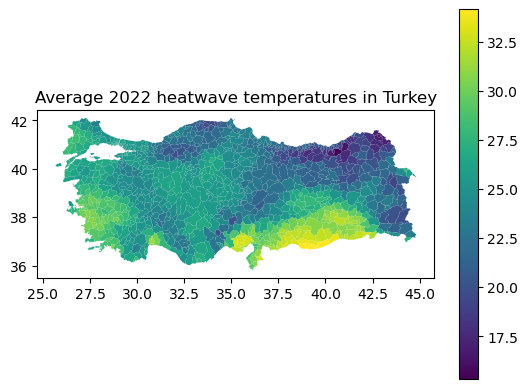

In [32]:
for_plot.plot(column='thi', legend=True)
plt.title("Average 2022 heatwave temperatures in Turkey")